In [318]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.learning_curve import validation_curve
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error
from sklearn.cluster import KMeans
import statsmodels.api as sm
import math
from scipy import stats
from scipy.stats import boxcox
from scipy.special import boxcox1p


# Load dataframe and add/clean columns

In [319]:
df = pd.read_csv('nfl_betting_df.csv', index_col = 0)

In [320]:
df['exp_win_difference'] = df.home_exp_win_pct- df.away_exp_win_pct
df['schedule_date']=df['schedule_date'].apply(pd.to_datetime)
df = df[df.schedule_season > 1978]

df['total_ppg'] = (df.h_ppg + df.a_ppg)
df['total_points_against'] = (df.h_papg + df.a_papg)
df['last_four_difference'] = (df.home_win_pct_last_4 - df.away_win_pct_last_4)

df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']]=df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']].fillna(value=np.round(df.mean(),3))
df[['over_under_line']]=df[['over_under_line']].fillna(value=(np.round(df.mean()*2)/2))

df['over_under_result'] = np.where(df['over_under_result']=='under', 0, df.over_under_result)
df['over_under_result'] = np.where(df['over_under_result']=='over', 1, df.over_under_result)
df['over_under_result'] = np.where(df['over_under_result']=='push', 2, df.over_under_result)

df['dome'] = np.where(df['weather_detail']=='DOME', 1, 0)

df = df.fillna(value = 0)

df.index = range(0, len(df))

In [321]:
reg_df = df[(df.schedule_week > 1) & (df.schedule_week < 19) & (df.schedule_season>2001)]
week5_df = df[(df.schedule_week > 4) & (df.schedule_week < 17) & (df.schedule_season>2001)]

# Regression Formulas

In [6]:
def poly_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max, alpha = .75,s = 5,width = 2.5):
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(x,y)
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)
    
#     #conditional to plot points in diff color depending on game outcome
#     if str(y) == str(reg_df.over_under_line):
#         y1 = y[week5_df['over_under_result']==1]
#         y2 = y[week5_df['over_under_result']==0]
#         y3 = y[week5_df['over_under_result']==2]
#         x1 = x[week5_df['over_under_result']==1]
#         x2 = x[week5_df['over_under_result']==0]
#         x3 = x[week5_df['over_under_result']==2]
#         plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
#         plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
#         plt.scatter(x3, y3, s = s, alpha = .4, color = 'yellow', label = 'Push')
#     else:
#         y1 = y[week5_df['favorite_covered']==1]
#         y2 = y[week5_df['favorite_covered']==0]
#         y3 = y[week5_df['favorite_covered']==2]
#         x1 = x[week5_df['favorite_covered']==1]
#         x2 = x[week5_df['favorite_covered']==0]
#         x3 = x[week5_df['favorite_covered']==2]
#         plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
#         plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
#         plt.scatter(x3, y3, s = s, alpha = .4, color = 'yellow', label = 'Push')
        
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xlim_min,xlim_max, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')


In [7]:
def log_linear_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max, alpha = .75,s = 5,width = 2.5):
    #create figure and set size and axis lims
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(x, np.log(np.abs(y)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)

    #conditional to plot points in diff color depending on game outcome
    if str(y) == str(reg_df.over_under_line):
        y1 = y[reg_df['over_under_result']==1]
        y2 = y[reg_df['over_under_result']==0]
        x1 = x[reg_df['over_under_result']==1]
        x2 = x[reg_df['over_under_result']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
    else:
        y1 = y[reg_df['favorite_covered']==1]
        y2 = y[reg_df['favorite_covered']==0]
        x1 = x[reg_df['favorite_covered']==1]
        x2 = x[reg_df['favorite_covered']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
    
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xlim_min,xlim_max, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')

In [8]:
def log_log_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max, alpha = .75,s = 5,width = 2.5):
    #create figure and set size and axis lims
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(np.log(x+1), np.log(np.abs(y)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)

    #conditional to plot points in diff color depending on game outcome
    if str(y) == str(reg_df.over_under_line):
        y1 = y[reg_df['over_under_result']==1]
        y2 = y[reg_df['over_under_result']==0]
        x1 = x[reg_df['over_under_result']==1]
        x2 = x[reg_df['over_under_result']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
    else:
        y1 = y[reg_df['favorite_covered']==1]
        y2 = y[reg_df['favorite_covered']==0]
        x1 = x[reg_df['favorite_covered']==1]
        x2 = x[reg_df['favorite_covered']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
    
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xlim_min,xlim_max, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')

# Regression Evaluations

In [9]:
def rmse_check(predictions, targets):

    differences = predictions - targets                       #the DIFFERENCEs.

    differences_squared = differences ** 2                    #the SQUAREs of ^

    mean_of_differences_squared = differences_squared.mean()  #the MEAN of ^

    rmse_val = np.sqrt(mean_of_differences_squared)           #ROOT of ^

    return rmse_val                                           #get the ^

In [10]:
def regression_evaluation(target, X_list):
    split = train_test_split(X_list, target,random_state=69)
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
     
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    rmse = math.sqrt(mean_squared_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted
    
    plt.scatter(y_predicted,residuals)
    check = round(rmse_check(y_predicted, y_actual) - rmse)
    print(est2.summary())
    plt.scatter(y_predicted,residuals)
    plt.show()
    sns.distplot(residuals)
    print('RMSE=' + str(rmse) + ', check =' + str(check))

In [11]:
def log_log_regression_evaluation(target, X_list):
    split = train_test_split((np.log(np.abs(X_list)+1)), np.log(np.abs(target)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
    
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    
    log_rmse = math.sqrt(mean_squared_log_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted

    #plt.scatter(y_predicted,residuals)
    print(est2.summary())
    sns.distplot(residuals)
    print('Log RMSE=' + str(log_rmse))

In [12]:
def log_linear_regression_evaluation(target,X_list):
    split = train_test_split(X_list, np.log(np.abs(target)+1))## log-linear eval
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
    
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    
    log_rmse = math.sqrt(mean_squared_log_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted

    #plt.scatter(y_predicted,residuals)
    print(est2.summary())
    sns.distplot(residuals)
    print('Log RMSE=' + str(log_rmse))

## BoxCox Transformation for Over Under Line

In [443]:
yt,max_lambda =boxcox(week5_df.over_under_line)
yt,max_lambda

(array([ 9.92849529, 11.98275459,  9.39153158, ..., 10.07720227,
        10.93097579, 10.99940315]), 0.4797960707341386)

# Variable 1 -Total Points Against

In [444]:
xt,max_lambda=boxcox(week5_df.total_points_against)
xt,max_lambda


(array([22.26252894, 37.73919657, 22.26252894, ..., 35.50470188,
        34.1161637 , 31.46228984]), 0.8968716137014843)

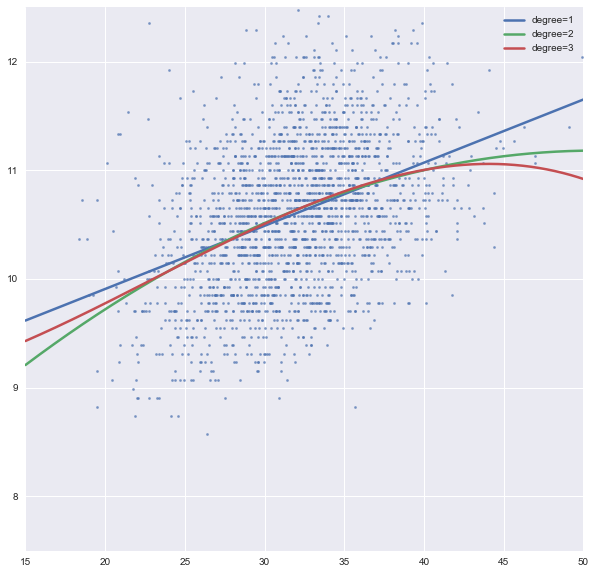

In [445]:
poly_regression(xt, yt,[1,2,3], 15,50, 7.5,12.5)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     388.7
Date:                Sun, 12 Aug 2018   Prob (F-statistic):           1.21e-79
Time:                        15:57:22   Log-Likelihood:                -2001.1
No. Observations:                2140   AIC:                             4006.
Df Residuals:                    2138   BIC:                             4017.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.7312      0.096     90.656      0.0

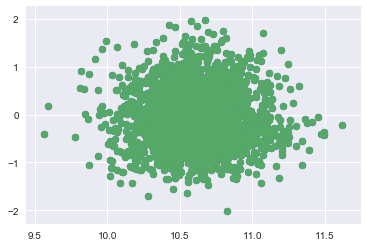

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



RMSE=0.6164031975541499, check =0.0


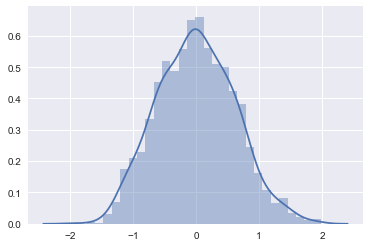

In [446]:
regression_evaluation(yt,xt)

# Variable 2 - Total PPG

In [324]:
yt,y_lambda =boxcox(week5_df.over_under_line)
xt,x_lambda = boxcox(week5_df.total_ppg)
xt,x_lambda

(array([13.64012663, 16.37513498, 11.54008118, ..., 11.57253937,
        12.8577737 , 13.51080374]), 0.5351249802774211)

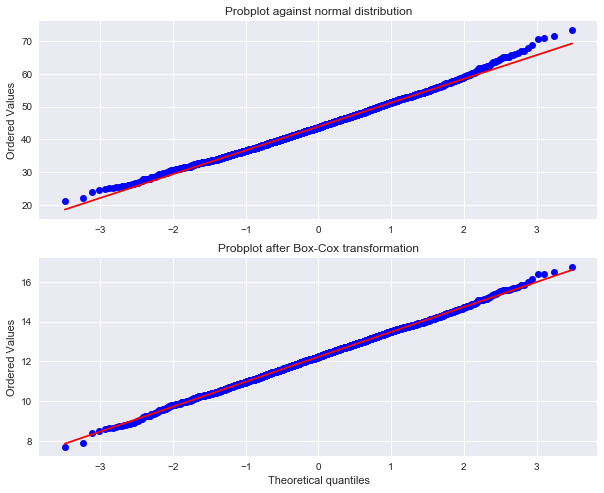

In [325]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
x = week5_df.total_ppg
prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(x)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()

In [326]:
week5_df.total_ppg.head()

5431    52.17
5432    70.67
5433    39.75
5434    39.42
5435    28.00
Name: total_ppg, dtype: float64

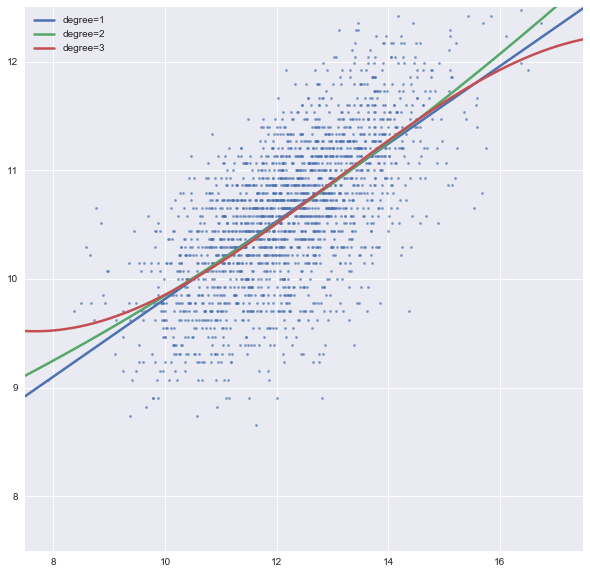

In [327]:
poly_regression(xt,yt,[1,2,3],7.5,17.5,7.5,12.5)

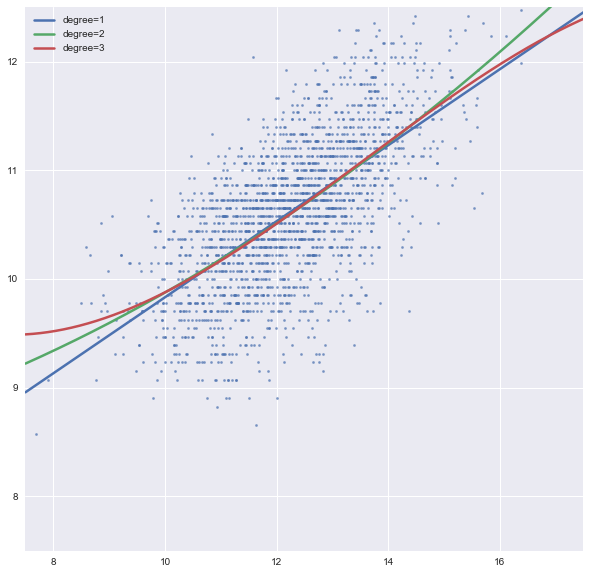

In [328]:
poly_regression(xt,yt,[1,2,3],7.5,17.5,7.5,12.5)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     1573.
Date:                Sun, 12 Aug 2018   Prob (F-statistic):          2.92e-258
Time:                        14:50:02   Log-Likelihood:                -1589.9
No. Observations:                2140   AIC:                             3184.
Df Residuals:                    2138   BIC:                             3195.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3230      0.109     58.165      0.0

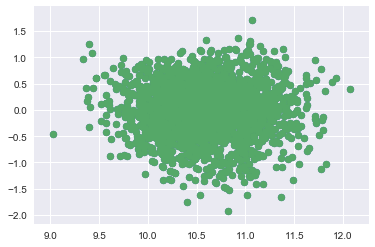

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



RMSE=0.5086546921676626, check =0.0


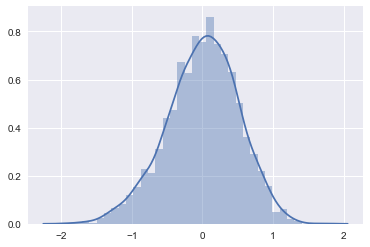

In [329]:
regression_evaluation(yt,xt)

# Variable 3 - Weather Temperature

In [330]:
yt,y_lambda =boxcox(week5_df.over_under_line)
xt,x_lambda = boxcox(week5_df.weather_temperature+1)
xt,x_lambda


(array([821.19850551, 524.98866338, 802.30741231, ..., 349.39459069,
        821.19850551, 182.89676765]), 1.6860354558041912)

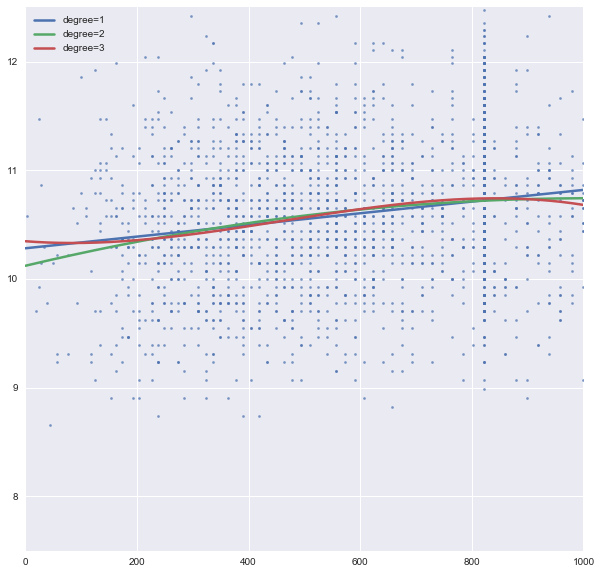

In [331]:
poly_regression(xt,yt,[1,2,3],0,1000,7.5,12.5)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     99.39
Date:                Sun, 12 Aug 2018   Prob (F-statistic):           6.50e-23
Time:                        14:50:03   Log-Likelihood:                -2131.2
No. Observations:                2140   AIC:                             4266.
Df Residuals:                    2138   BIC:                             4278.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.2593      0.038    269.344      0.0

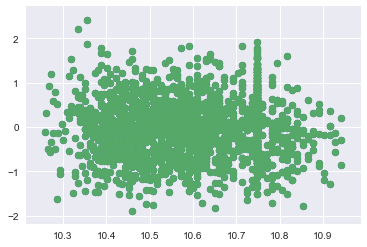

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



RMSE=0.6550496084341897, check =0.0


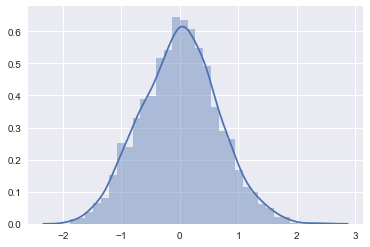

In [332]:
regression_evaluation(yt,xt)

# Variable 4 - Weather Wind mph

In [333]:
yt,y_lambda =boxcox(week5_df.over_under_line)
xt,x_lambda = boxcox(week5_df.weather_wind_mph+1)
xt,x_lambda

(array([0.        , 3.61583925, 3.11772041, ..., 3.11772041, 0.        ,
        4.8082095 ]), 0.36638065933896274)

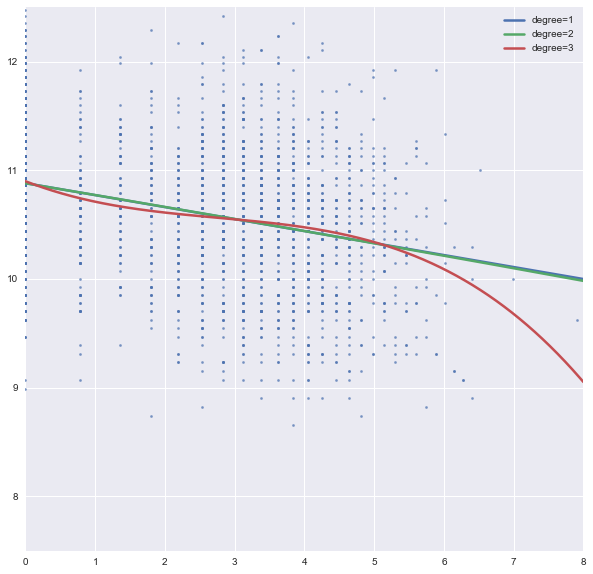

In [334]:
poly_regression(xt,yt,[1,2,3],0,8,7.5,12.5)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     252.7
Date:                Sun, 12 Aug 2018   Prob (F-statistic):           7.31e-54
Time:                        14:50:04   Log-Likelihood:                -2060.3
No. Observations:                2140   AIC:                             4125.
Df Residuals:                    2138   BIC:                             4136.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.9153      0.024    464.470      0.0

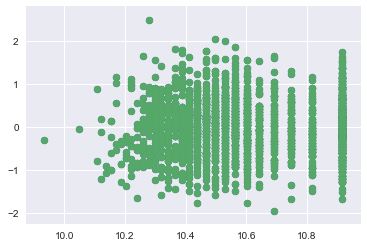

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



RMSE=0.6337025877592596, check =0.0


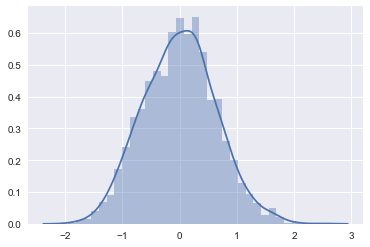

In [335]:
regression_evaluation(yt,xt)

# Variable 5 - Weather Humidity

In [336]:
yt,y_lambda =boxcox(week5_df.over_under_line)
xt,x_lambda = boxcox(week5_df.weather_humidity)
xt,x_lambda

(array([1053.46674788, 1124.18615108, 1213.61937773, ..., 1053.46674788,
        1053.46674788, 1053.46674788]), 1.7977446240992794)

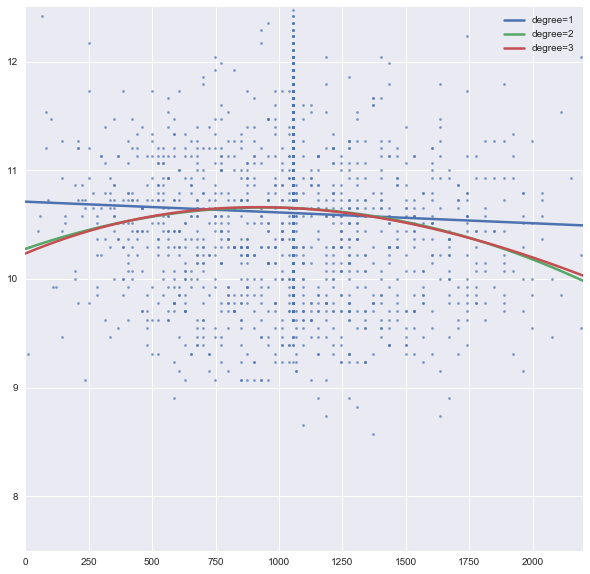

In [337]:
poly_regression(xt,yt,[1,2,3],0,2200,7.5,12.5)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     10.07
Date:                Sun, 12 Aug 2018   Prob (F-statistic):            0.00153
Time:                        14:50:07   Log-Likelihood:                -2174.8
No. Observations:                2140   AIC:                             4354.
Df Residuals:                    2138   BIC:                             4365.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.7570      0.048    224.115      0.0

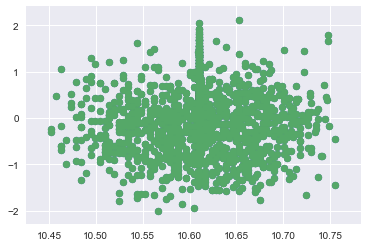

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



RMSE=0.6685306109083531, check =0.0


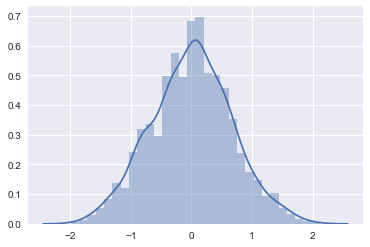

In [338]:
regression_evaluation(yt,xt)

# Variable 6 - Dome

In [339]:
yt,y_lambda =boxcox(week5_df.over_under_line)
xt,x_lambda = boxcox(week5_df.dome+1)
xt,x_lambda

(array([0.16971635, 0.        , 0.        , ..., 0.        , 0.16971635,
        0.        ]), -5.7853494137090555)

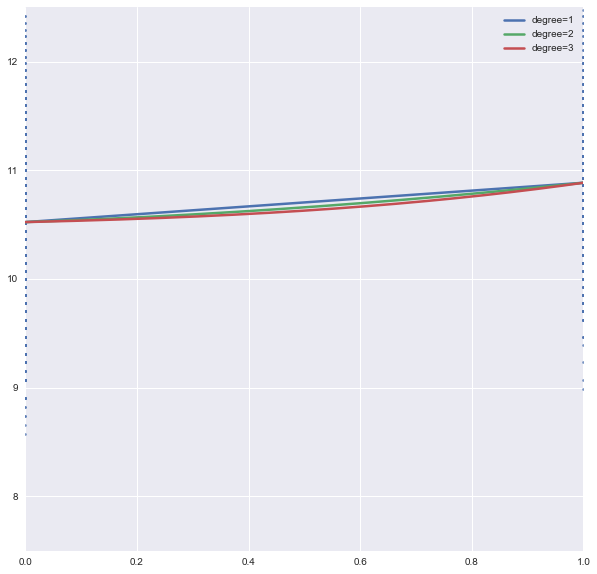

In [340]:
poly_regression(week5_df.dome,yt,[1,2,3],0,1,7.5,12.5)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     166.7
Date:                Sun, 12 Aug 2018   Prob (F-statistic):           8.67e-37
Time:                        14:50:08   Log-Likelihood:                -2099.5
No. Observations:                2140   AIC:                             4203.
Df Residuals:                    2138   BIC:                             4214.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.5114      0.016    657.834      0.0

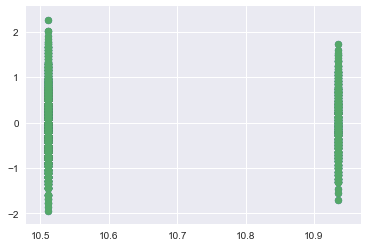

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



RMSE=0.6454064721781986, check =0.0


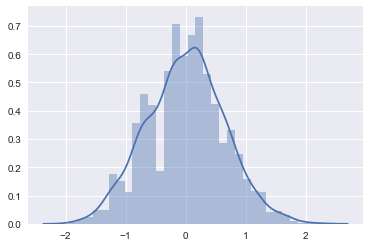

In [341]:
regression_evaluation(yt,week5_df.dome)

# variable 7 - season

In [342]:
xt7,xlam7=boxcox(week5_df.schedule_season)
xt7,xlam7
max(xt7)

0.6305293949256964

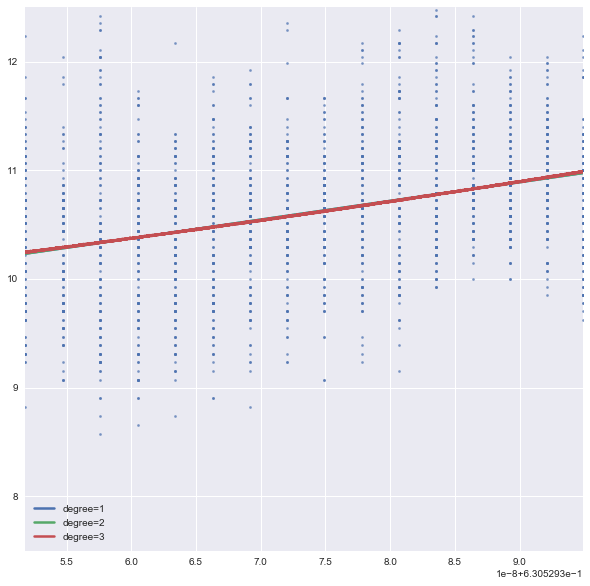

In [343]:
poly_regression(xt7,yt,[1,2,3],.6305293518286147,.6305293949256964,7.5,12.5)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     284.6
Date:                Sun, 12 Aug 2018   Prob (F-statistic):           4.75e-60
Time:                        14:50:09   Log-Likelihood:                -2046.1
No. Observations:                2140   AIC:                             4096.
Df Residuals:                    2138   BIC:                             4108.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.095e+07   6.49e+05    -16.871      0.0

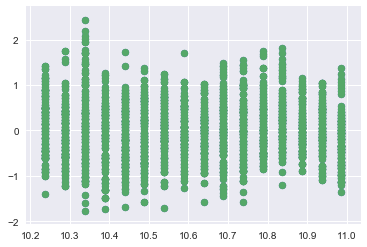

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



RMSE=0.6295090088624903, check =0.0


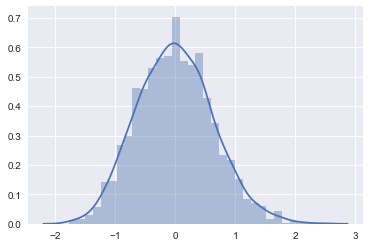

In [344]:
regression_evaluation(yt,xt7)

# Regression of over under with all variables

In [378]:
yt,y_lambda =boxcox(week5_df.over_under_line)
xt1,xlam1 = boxcox(week5_df.total_points_against)
xt2,xlam2 = boxcox(week5_df.total_ppg)
xt3,xlam3 = boxcox(week5_df.weather_temperature+1)
xt4,xlam4 = boxcox(week5_df.weather_wind_mph+1)
xt5,xlam5 = boxcox(week5_df.weather_humidity)
xt7,xlam7=boxcox(week5_df.schedule_season)
ou_regression_df = pd.DataFrame([xt1,xt2,xt3,xt4,xt5,week5_df.dome,xt7]).T
ou_regression_df.columns=['Total Points Against','Total PPG','Temp','Wind MPH','Humidity','Dome','Season']
ou_regression_df.head()
len(ou_regression_df)

2854

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     703.0
Date:                Sun, 12 Aug 2018   Prob (F-statistic):               0.00
Time:                        14:55:26   Log-Likelihood:                -899.74
No. Observations:                2140   AIC:                             1815.
Df Residuals:                    2132   BIC:                             1861.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -2.576e+06 

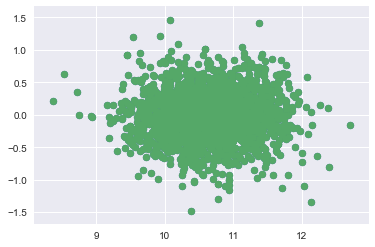

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



RMSE=0.36843151723373724, check =-0.0


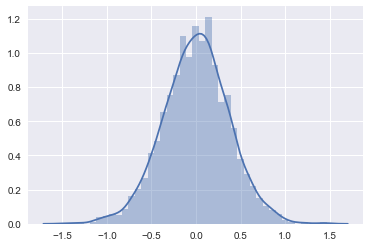

In [379]:
regression_evaluation(yt,ou_regression_df)

# Distribution of Scores

In [37]:
scores_df = week5_df[['score_home','score_away']]

In [39]:
home_scores = list(scores_df.score_home)
away_scores = list(scores_df.score_away)
all_scores = []
all_scores.extend(home_scores)
all_scores.extend(away_scores)
all_scores=np.array(all_scores)

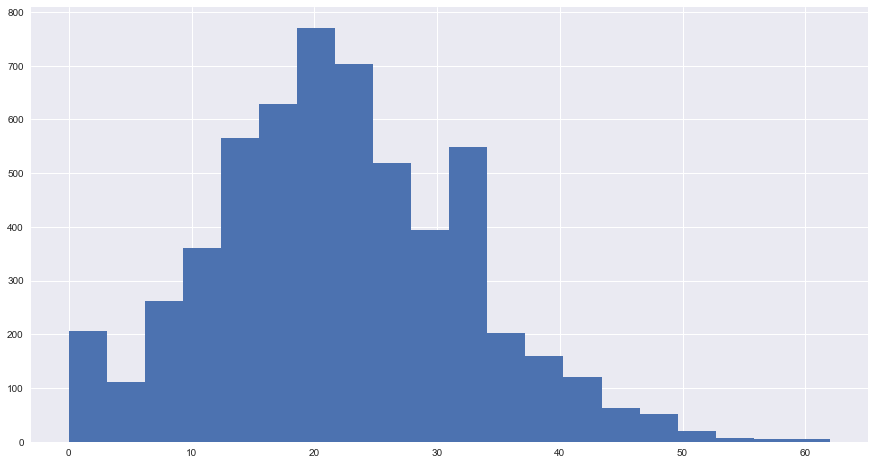

In [40]:
plt.figure(figsize=(15,8))
plt.hist(all_scores,bins=20);

In [41]:
len(all_scores)

5708

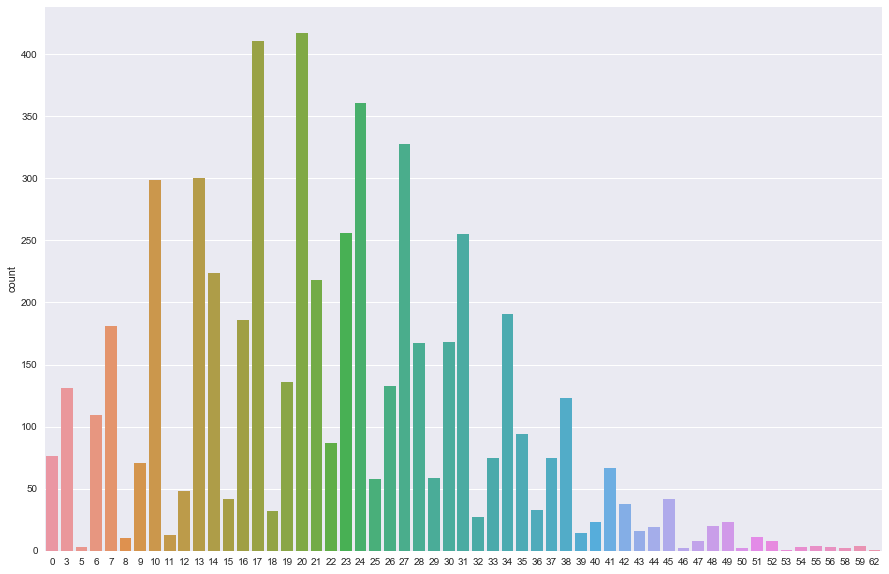

In [42]:
import collections
score_freq = collections.Counter(all_scores)
score_freq

from operator import itemgetter  

# for key, value in sorted(score_freq.items(), key = itemgetter(1), reverse = True):
#     print(key, value)

plt.figure(figsize=(15,10))
sns.countplot(all_scores)

In [ ]:
factor = FactorAnalysis(n_components=5).fit(scores_df)

In [ ]:
factor.components_

In [ ]:
9^8

RangeIndex(start=0, stop=1, step=1)

# Cluster Analysis Regression

In [386]:
cluster_df = pd.read_csv('cluster_df.csv',index_col=0)

In [387]:
good_o_bad_d = cluster_df[cluster_df.cluster==3]
good_o_good_d = cluster_df[cluster_df.cluster==0]
bad_o_bad_d = cluster_df[cluster_df.cluster==1]
bad_o_good_d = cluster_df[cluster_df.cluster==2]

# Good Offense Bad Defense

# Variable 1 - h_ppg

In [388]:
yt,ylam = boxcox(good_o_bad_d.score_home+1)
yt,ylam

(array([ 5.11123948, 19.16252683, 20.46840085, 19.16252683, 16.51230858,
        24.95375727, 13.11365446, 24.95375727, 15.84085839, 15.16549075,
        24.95375727, 10.30708995, 15.16549075, 15.16549075, 17.84420647,
        17.84420647, 10.30708995, 24.32036358, 19.81695584, 15.16549075,
        15.16549075, 21.76279405, 15.84085839, 13.11365446, 17.18003303,
         8.13469256, 15.16549075, 24.32036358, 17.18003303, 11.01737538,
        20.46840085,  5.88409017,  8.13469256, 17.84420647, 17.84420647,
        19.81695584, 29.32816982, 19.16252683, 24.95375727, 17.84420647,
         8.13469256, 24.95375727, 13.11365446, 24.32036358, 15.16549075,
        15.16549075, 10.30708995, 13.11365446, 20.46840085, 17.84420647,
        24.32036358,  8.13469256, 19.16252683, 26.84072476, 13.11365446,
        12.42025969, 13.11365446, 19.81695584, 21.76279405, 23.68465007,
        22.40595015, 17.84420647, 26.84072476, 10.30708995, 30.56065133,
        15.16549075, 19.81695584, 24.32036358, 33.0

In [399]:
xt1,xlam1 = boxcox(good_o_bad_d.h_ppg)
xt1,xlam1

(array([6.40584063, 6.24692624, 6.36013131, 7.25414878, 6.28811408,
        5.92024205, 6.34255379, 7.07808611, 7.5367262 , 7.31171469,
        7.14559896, 5.56557262, 6.05332214, 6.88805773, 6.83492055,
        4.52156455, 6.6610141 , 6.17757967, 6.82124901, 6.08323714,
        6.28811408, 6.12145515, 5.97851492, 6.1355412 , 6.86834231,
        6.73221973, 5.63880924, 5.92756154, 6.19847687, 6.22067877,
        6.76372494, 6.05617842, 5.69113735, 6.7599534 , 5.79121309,
        6.12145515, 5.76109223, 5.2228166 , 6.54859436, 7.16676172,
        6.49351106, 5.42873361, 6.7347465 , 6.7599534 , 7.14913127,
        6.38303317, 6.0361522 , 5.61865818, 6.98202112, 5.964007  ,
        6.60702074, 5.45608296, 5.93925157, 6.92240054, 6.93705749,
        5.93925157, 5.67580245, 6.70942859, 5.81667854, 6.53160239,
        6.70942859, 5.69113735, 6.73727217, 5.72471309, 5.77165454,
        6.50272923, 7.03024813, 6.72083547, 6.60443679, 5.44323148,
        6.31540139, 6.0718607 , 6.53814383, 6.79

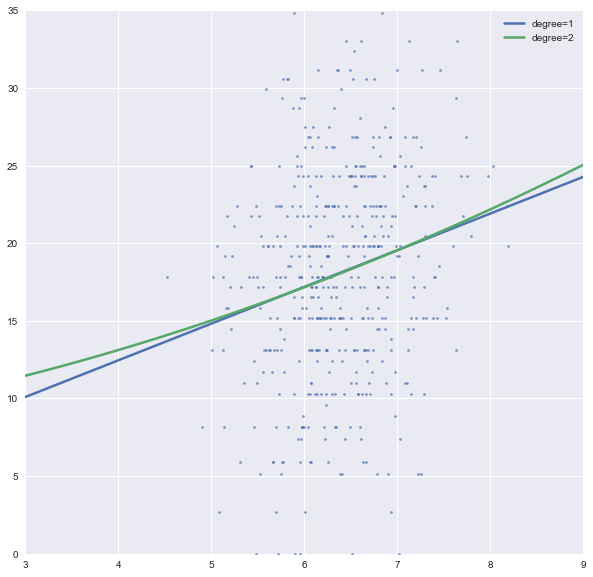

In [396]:
poly_regression(xt1,yt,[1,2],3,9,0,35)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     20.31
Date:                Sun, 12 Aug 2018   Prob (F-statistic):           8.31e-06
Time:                        15:08:13   Log-Likelihood:                -1603.1
No. Observations:                 480   AIC:                             3210.
Df Residuals:                     478   BIC:                             3219.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2588      3.480      0.649      0.5

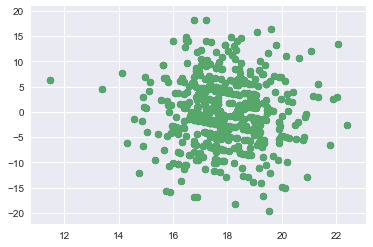

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



RMSE=6.826928678090459, check =0.0


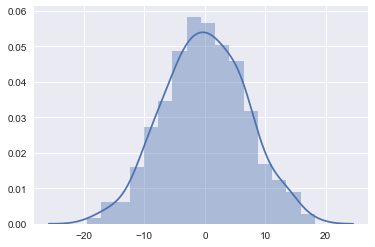

In [397]:
regression_evaluation(yt,xt1)

# variable 2 -total papg

In [402]:
xt2,xlam1 = boxcox(good_o_bad_d.a_papg)
xt2,xlam1
print(min(xt2))
print(max(xt2))

5.790114147699591
27.324189933176974


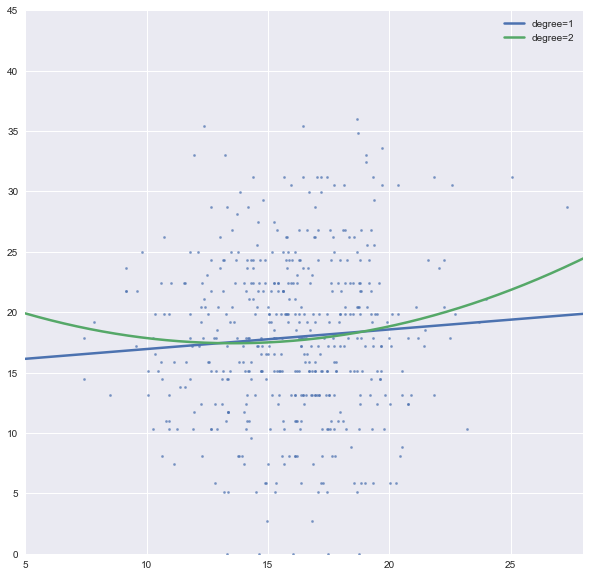

In [403]:
poly_regression(xt2,yt,[1,2],5,28,0,45)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.399
Date:                Sun, 12 Aug 2018   Prob (F-statistic):             0.0658
Time:                        15:13:26   Log-Likelihood:                -1611.4
No. Observations:                 480   AIC:                             3227.
Df Residuals:                     478   BIC:                             3235.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.7845      1.708      8.656      0.0

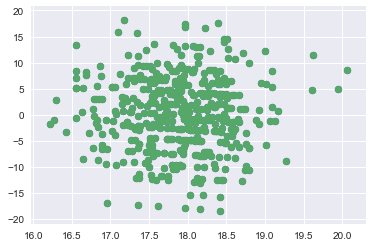

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



RMSE=6.945774133460805, check =0.0


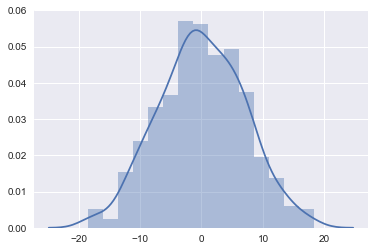

In [405]:
regression_evaluation(yt,xt2)

# variable 3 - weather temp

In [408]:
xt3,xlam3 = boxcox(good_o_bad_d.weather_temperature+1)
xt3,xlam3
print(min(xt3))
print(max(xt3))

22.148877846534507
485.98858055068854


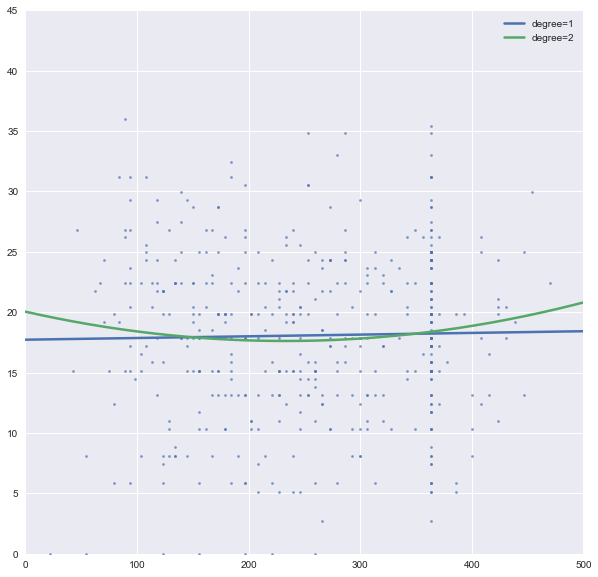

In [409]:
poly_regression(xt3,yt,[1,2],0,500,0,45)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.03216
Date:                Sun, 12 Aug 2018   Prob (F-statistic):              0.858
Time:                        15:40:42   Log-Likelihood:                -1613.1
No. Observations:                 480   AIC:                             3230.
Df Residuals:                     478   BIC:                             3239.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.7270      0.903     19.642      0.0

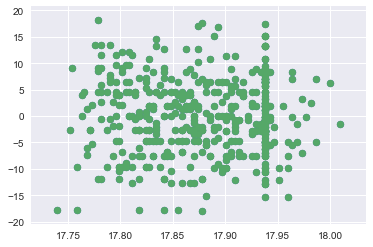

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



RMSE=6.970192072823221, check =0.0


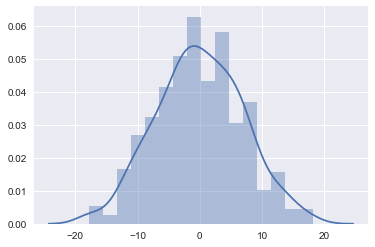

In [410]:
regression_evaluation(yt,xt3)

# variable 4 - weather wind mph

In [413]:
xt4,xlam = boxcox(good_o_bad_d.weather_wind_mph+1)
xt4,xlam

print(min(xt4))
print(max(xt4))

0.0
6.997479005838197


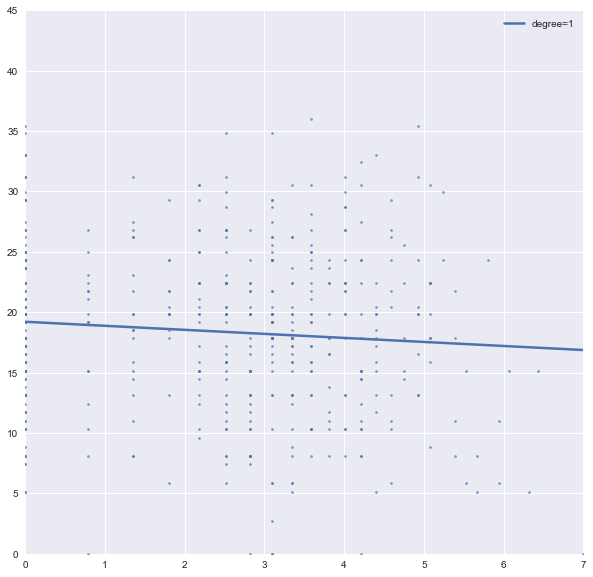

In [415]:
poly_regression(xt4,yt,[1],0,7,0,45)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     4.979
Date:                Sun, 12 Aug 2018   Prob (F-statistic):             0.0261
Time:                        15:41:33   Log-Likelihood:                -1610.6
No. Observations:                 480   AIC:                             3225.
Df Residuals:                     478   BIC:                             3234.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.8770      0.549     34.415      0.0

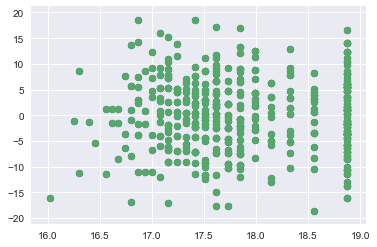

RMSE=6.934404285862548, check =0.0


/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



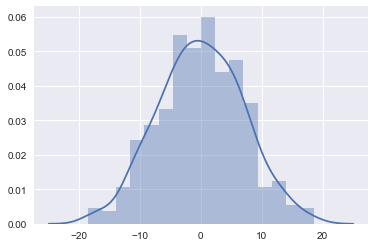

In [416]:
regression_evaluation(yt,xt4)

# variable 5 - weather humidity

In [417]:
xt5,xlam = boxcox(good_o_bad_d.weather_humidity+1)
xt5,xlam

print(min(xt5))
print(max(xt5))

89.54570011402441
4333.619158863061


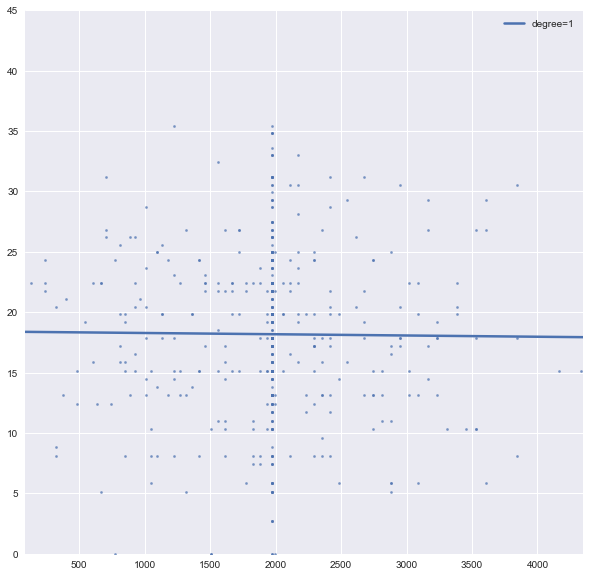

In [419]:
poly_regression(xt5,yt,[1],89,4350,0,45)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.746
Date:                Sun, 12 Aug 2018   Prob (F-statistic):              0.187
Time:                        15:42:05   Log-Likelihood:                -1612.2
No. Observations:                 480   AIC:                             3228.
Df Residuals:                     478   BIC:                             3237.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.1557      1.018     18.821      0.0

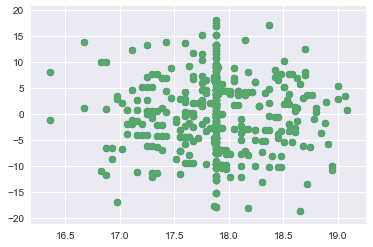

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



RMSE=6.957734154300206, check =0.0


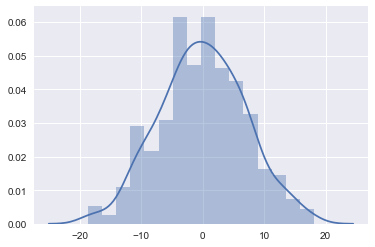

In [420]:
regression_evaluation(yt,xt5)

In [439]:
name=good_o_good_d

yt,y_lambda =boxcox(name.score_home+1)

xt1,xlam1 = boxcox(name.h_ppg)
xt2,xlam2 = boxcox(name.a_papg)
xt3,xlam3 = boxcox(name.weather_wind_mph+1)
xt4,xlam4 = boxcox(name.weather_humidity)

test_reg_df = pd.DataFrame([xt1,xt2]).T
test_reg_df.columns=['Home PPG','Away PAPG']
test_reg_df.tail()

,Home PPG,Away PAPG
758,17.284800,18.193708
759,23.252791,17.636571
760,16.549065,20.593833
761,18.471820,17.235363
762,15.631468,18.521380


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     26.19
Date:                Sun, 12 Aug 2018   Prob (F-statistic):           1.32e-11
Time:                        15:47:57   Log-Likelihood:                -1652.5
No. Observations:                 572   AIC:                             3311.
Df Residuals:                     569   BIC:                             3324.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8291      1.364      2.074      0.0

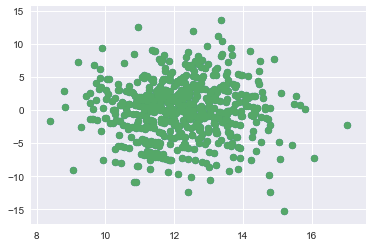

/Users/SamLiebman/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



RMSE=4.349383417381766, check =0.0


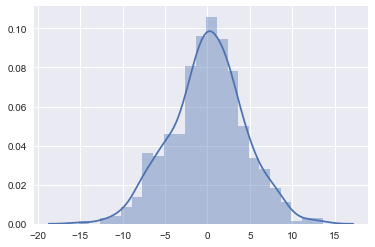

In [440]:
regression_evaluation(yt,test_reg_df)

# variable 6 - dome

# variable 7 - season